In [1002]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load data

In [1004]:
path_data = 'https://raw.githubusercontent.com/adamcohen3/caseload_forecasting/refs/heads/main/Final_forecast_data/'

In [1005]:
# Read the Excel file directly from the URL
df_caseload = pd.read_csv(path_data + 'data_forecast_cases.csv')
df_pred = pd.read_csv(path_data + 'SocioEconomic_data.csv')
df_caseload.head()

,Year,Circuit,Type of Action,Pending at Start,Filed,Total Caseload,Terminated,Pending at End
0,1998,Fifth Circuit,Civil Actions,645.0,410.0,1055.0,350.0,705.0
1,1998,Fifth Circuit,Criminal Actions,222.0,249.0,471.0,292.0,179.0
2,1998,First Circuit,Civil Actions,8369.0,5616.0,13985.0,5978.0,8007.0
3,1998,First Circuit,Criminal Actions,2454.0,3415.0,5869.0,3524.0,2345.0
4,1998,Second Circuit,Civil Actions,1520.0,995.0,2515.0,936.0,1579.0


In [1006]:
# unique cases for caseload
df_caseload['Type of Action'].unique()

array(['Civil Actions', 'Criminal Actions', 'Civil', 'Criminal',
       'Motions', 'Original Proceedings', 'Total Appeals',
       'Adoption Proceedings', 'Marital Actions and Proceedings',
       'Parental Proceedings', 'Traffic Violations'], dtype=object)

In [1007]:
df_pred.head(5)

,Year,Total population(thousands),Population growth(%),GDP (million dollars),GDP per Capita (dollars),Honolulu CPI-U (1982-84=100),Civilian unemployment rate (%),Judiciary funding(USD),Median income(USD),Gini coefficient,Poverty rate(%),Crime rate(%),Size of HPD,Government size,Graduation Rate(%),Health Insurance Coverage Rate(%)
0,1997,"1,212",0.7,"37,702","31,116",171.9,5.9,NaN,NaN,NaN,13.9,NaN,NaN,NaN,NaN,NaN
1,1998,"1,215",0.3,"37,503","30,861",171.5,5.8,NaN,NaN,NaN,10.9,NaN,NaN,NaN,NaN,NaN
2,1999,"1,210",-0.4,"38,970","32,199",173.3,5.2,NaN,NaN,NaN,10.8,NaN,NaN,NaN,NaN,NaN
3,2000,"1,214",0.3,"41,089","33,860",176.3,4.2,NaN,NaN,0.4270,8.8,NaN,NaN,NaN,NaN,NaN
4,2001,"1,226",1.0,"42,500","34,667",178.4,4.6,NaN,NaN,0.4323,10.4,NaN,NaN,NaN,NaN,NaN


In [1008]:
# check datatype for each feature to make sure everything has right datatype
df_pred.info(), df_caseload.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Year                               34 non-null     int64  
 1   Total population(thousands)        31 non-null     object 
 2   Population growth(%)               31 non-null     float64
 3   GDP (million dollars)              31 non-null     object 
 4   GDP per Capita (dollars)           31 non-null     object 
 5   Honolulu CPI-U (1982-84=100)       31 non-null     float64
 6   Civilian unemployment rate (%)     31 non-null     float64
 7   Judiciary funding(USD)             0 non-null      float64
 8   Median income(USD)                 0 non-null      float64
 9   Gini coefficient                   23 non-null     float64
 10  Poverty rate(%)                    27 non-null     float64
 11  Crime rate(%)                      0 non-null      float64
 

(None, None)

In [1009]:
# convert string columns into float
df_pred['Total population(thousands)'] = df_pred['Total population(thousands)'].str.replace(',', '').astype(float)
df_pred['GDP per Capita (dollars)'] = df_pred['GDP per Capita (dollars)'].str.replace(',', '').astype(float)

In [1010]:
# select predictors that we have data for the stuy period
df_pred = df_pred[['Year', 'Total population(thousands)', 'GDP per Capita (dollars)', 'Honolulu CPI-U (1982-84=100)', 'Civilian unemployment rate (%)', 'Poverty rate(%)']]

# Data Exploration
Visualizing how data changes over years across different circuit court. If the ratio of cases stays constant approximately, we can only predict for the total cases and then break it down to circuits based on ratios.

It seems that Filed cases are more stable than Total and Terminated cases.

In [1012]:
df_caseload['Year'].unique()

array([1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020, 2021, 2022, 2023], dtype=int64)

In [1013]:
## Group by Year and Action, and calculate the total and then ratio for each Action
# Filed cases
df_caseload['Sum_Filed'] = df_caseload.groupby(['Year', 'Type of Action'])['Filed'].transform('sum')
df_caseload['Ratio_Filed'] = df_caseload['Filed'] / df_caseload['Sum_Filed']
# Total cases
df_caseload['Sum_Total'] = df_caseload.groupby(['Year', 'Type of Action'])['Total Caseload'].transform('sum')
df_caseload['Ratio_Total'] = df_caseload['Total Caseload'] / df_caseload['Sum_Total']
# Terminated cases
df_caseload['Sum_Terminated'] = df_caseload.groupby(['Year', 'Type of Action'])['Terminated'].transform('sum')
df_caseload['Ratio_Terminated'] = df_caseload['Terminated'] / df_caseload['Sum_Terminated']

df_caseload

,Year,Circuit,Type of Action,Pending at Start,Filed,Total Caseload,Terminated,Pending at End,Sum_Filed,Ratio_Filed,Sum_Total,Ratio_Total,Sum_Terminated,Ratio_Terminated
0,1998,Fifth Circuit,Civil Actions,645.0,410.0,1055.0,350.0,705.0,8021.0,0.051116,20570.0,0.051288,8226.0,0.042548
1,1998,Fifth Circuit,Criminal Actions,222.0,249.0,471.0,292.0,179.0,5217.0,0.047729,8950.0,0.052626,5133.0,0.056887
2,1998,First Circuit,Civil Actions,8369.0,5616.0,13985.0,5978.0,8007.0,8021.0,0.700162,20570.0,0.679874,8226.0,0.726720
3,1998,First Circuit,Criminal Actions,2454.0,3415.0,5869.0,3524.0,2345.0,5217.0,0.654591,8950.0,0.655754,5133.0,0.686538
4,1998,Second Circuit,Civil Actions,1520.0,995.0,2515.0,936.0,1579.0,8021.0,0.124049,20570.0,0.122265,8226.0,0.113786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,2022,Second Circuit,Traffic Violations,9187.0,33080.0,42267.0,36739.0,5528.0,344537.0,0.096013,550618.0,0.076763,390221.0,0.094149
750,2023,First Circuit,Traffic Violations,124494.0,237323.0,362217.0,260016.0,102201.0,314942.0,0.753545,490115.0,0.739045,350529.0,0.741782
751,2023,Second Circuit,Traffic Violations,10344.0,29734.0,40078.0,34048.0,6030.0,314942.0,0.094411,490115.0,0.081773,350529.0,0.097133
752,2023,Third Circuit,Traffic Violations,31478.0,36988.0,68466.0,42718.0,25748.0,314942.0,0.117444,490115.0,0.139694,350529.0,0.121867


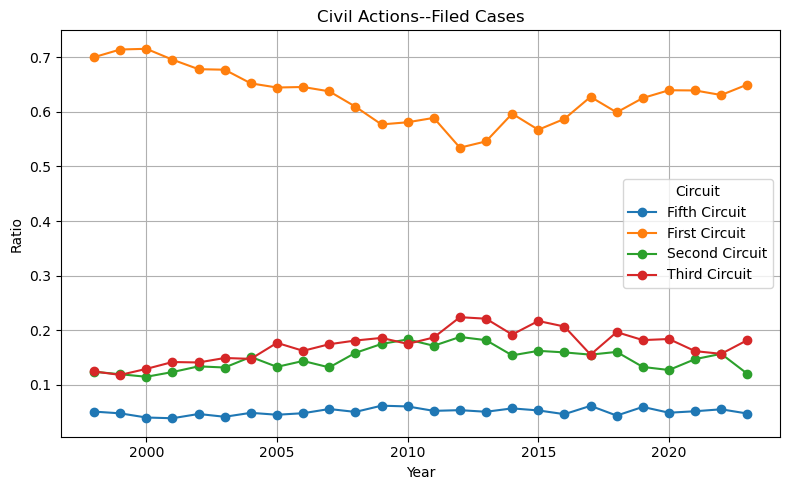

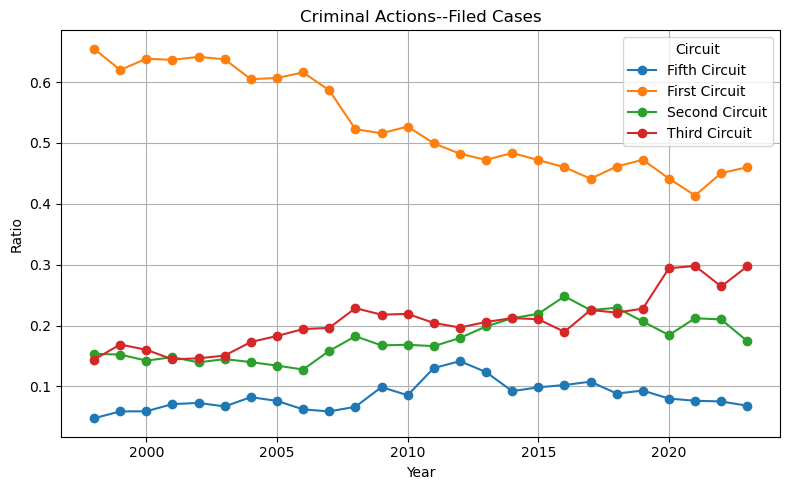

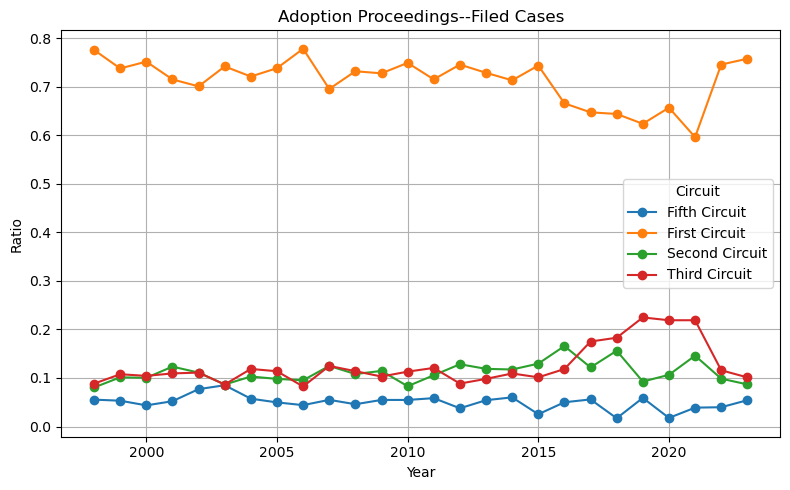

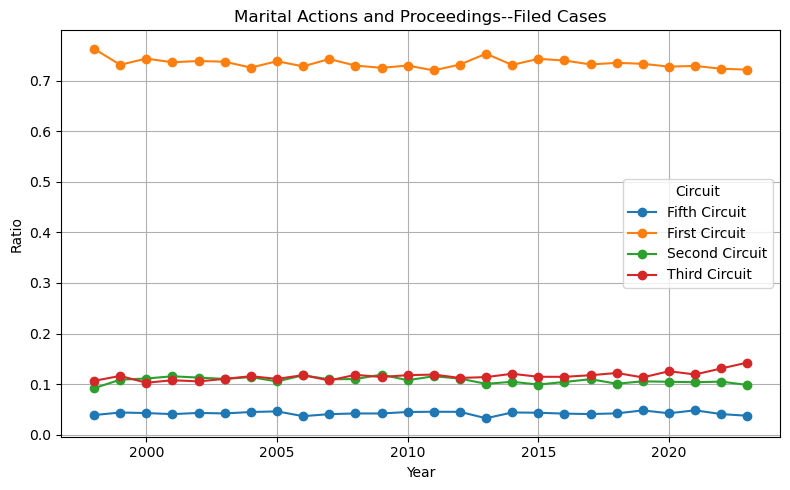

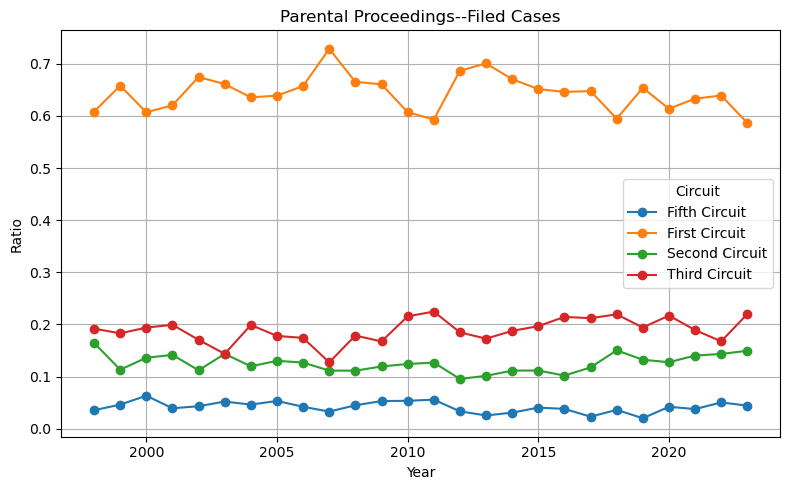

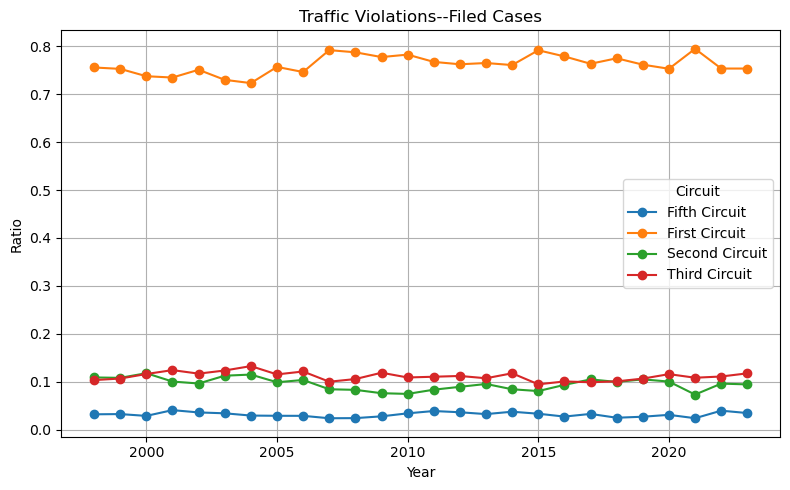

In [1014]:
## Plot ratios for each type of filed cases
# Group data by Case. COA cases were removed from the plot since the ratio is always one as the only one available
actions = df_caseload[df_caseload['Circuit'] != 'COA']['Type of Action'].unique()

# Plot each Case separately
for action in actions:
    # Filter the data for the current Action
    action_df = df_caseload[df_caseload['Type of Action'] == action]
    
    # Pivot data for easier plotting
    pivot_df = action_df.pivot_table(index='Year', columns='Circuit', values='Ratio_Filed')

    # Plot
    plt.figure(figsize=(8, 5))
    for circuit in pivot_df.columns:
        plt.plot(pivot_df.index, pivot_df[circuit], marker='o', label=f'{circuit}')
    
    # Add labels, title, and legend
    plt.xlabel('Year')
    plt.ylabel('Ratio')
    plt.title(f'{action}--Filed Cases')
    plt.legend(title='Circuit')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

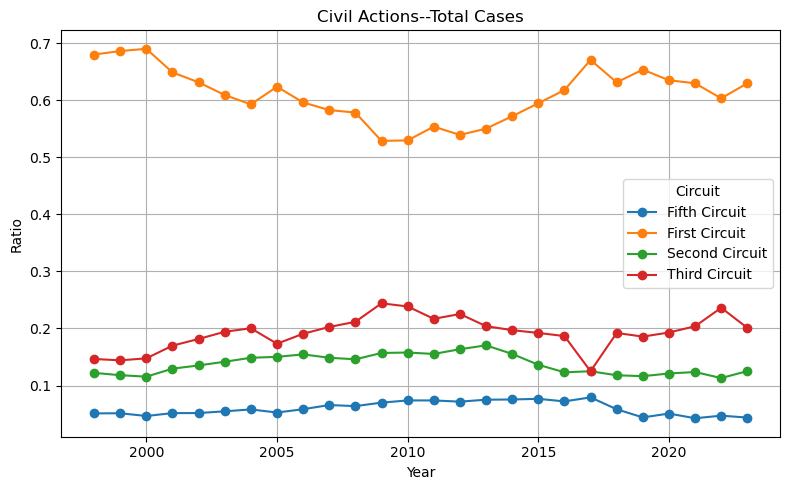

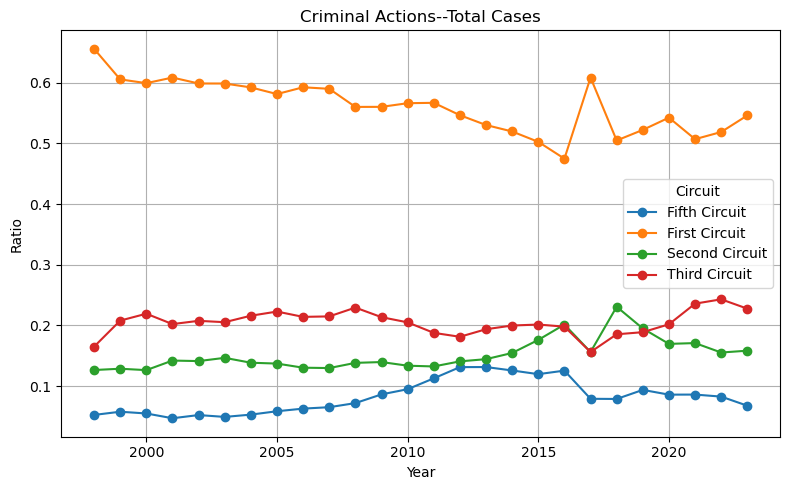

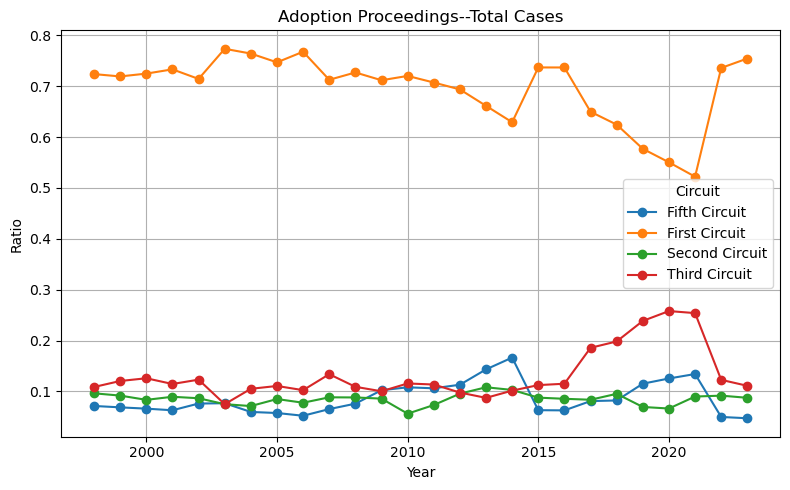

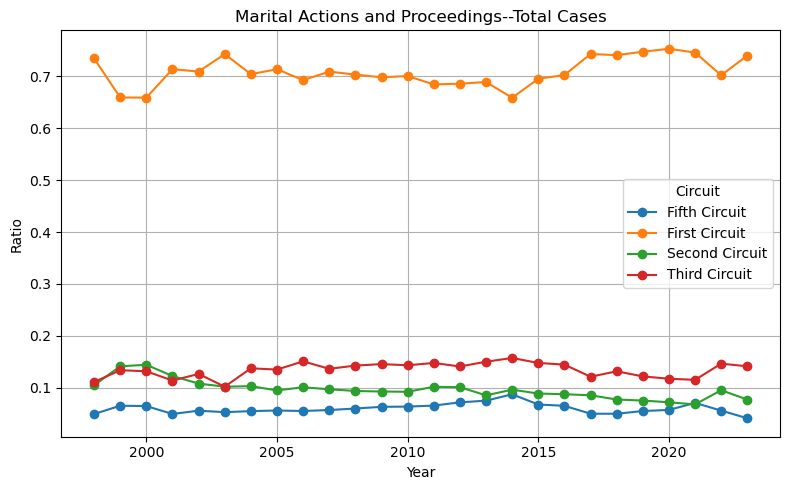

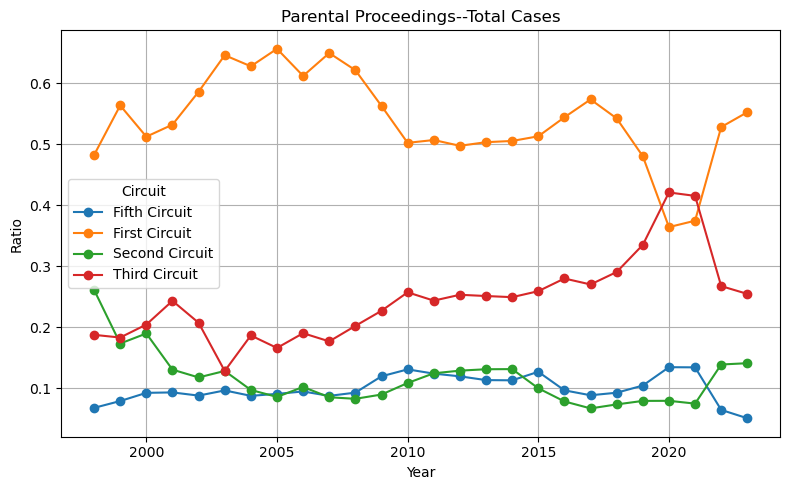

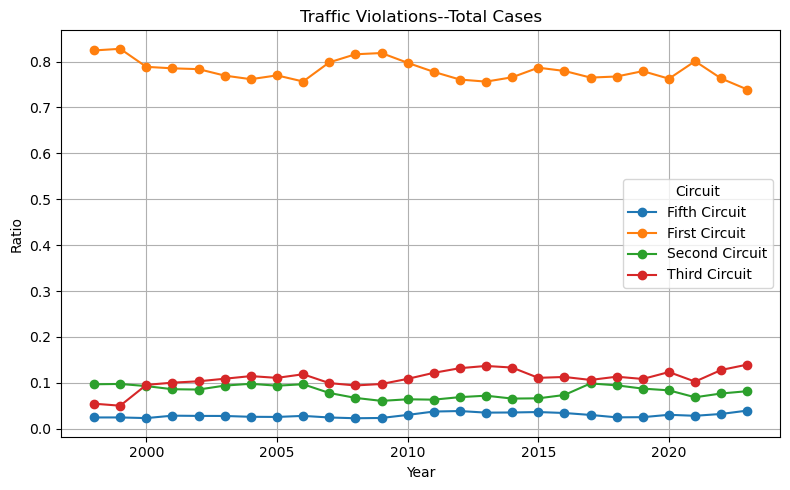

In [1015]:
## Plot ratios for each type of Total cases
# Group data by Case. COA cases were removed from the plot since the ratio is always one as the only one available
actions = df_caseload[df_caseload['Circuit'] != 'COA']['Type of Action'].unique()

# Plot each Case separately
for action in actions:
    # Filter the data for the current Action
    action_df = df_caseload[df_caseload['Type of Action'] == action]
    
    # Pivot data for easier plotting
    pivot_df = action_df.pivot_table(index='Year', columns='Circuit', values='Ratio_Total')

    # Plot
    plt.figure(figsize=(8, 5))
    for circuit in pivot_df.columns:
        plt.plot(pivot_df.index, pivot_df[circuit], marker='o', label=f'{circuit}')
    
    # Add labels, title, and legend
    plt.xlabel('Year')
    plt.ylabel('Ratio')
    plt.title(f'{action}--Total Cases')
    plt.legend(title='Circuit')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

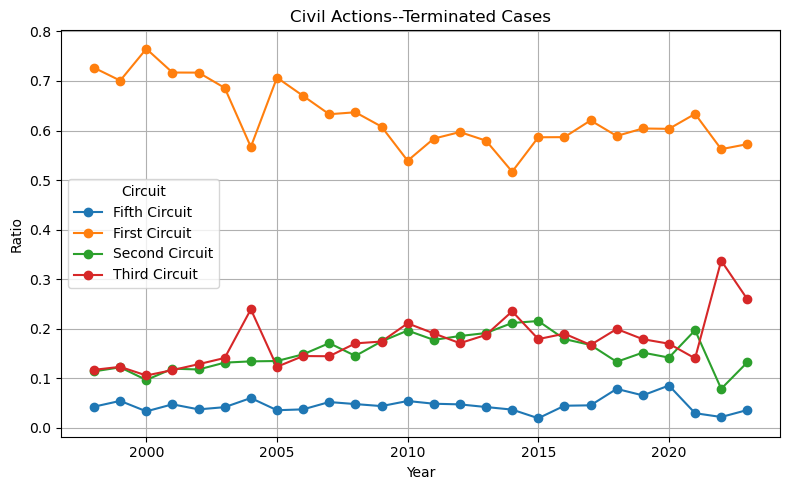

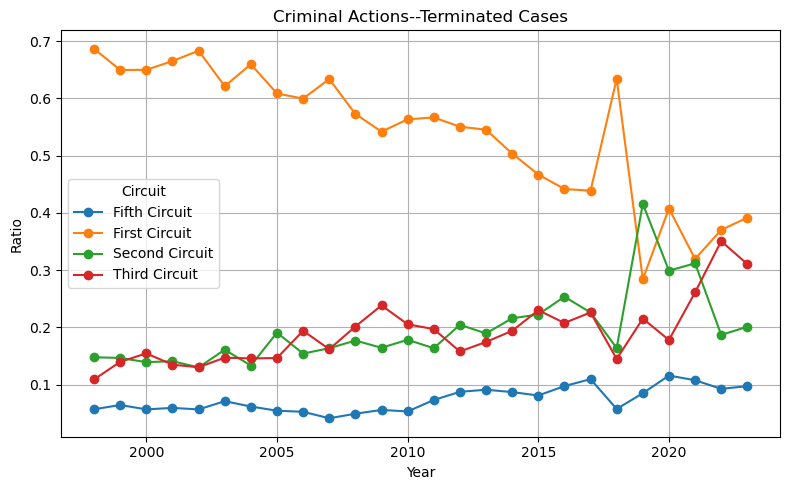

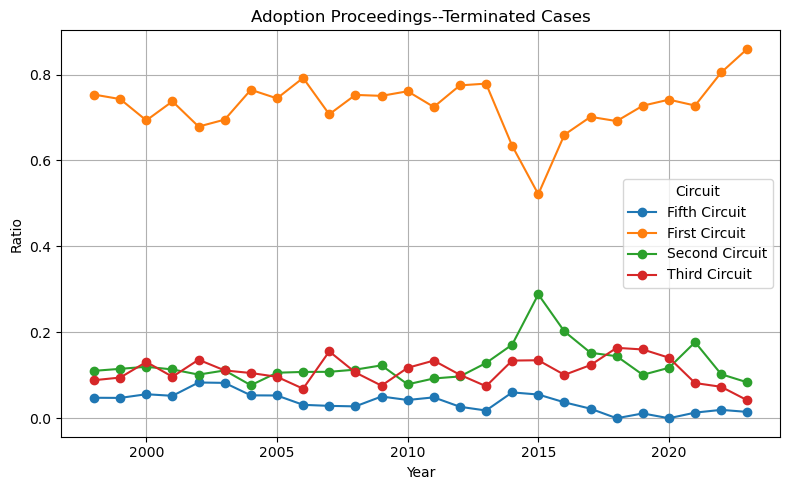

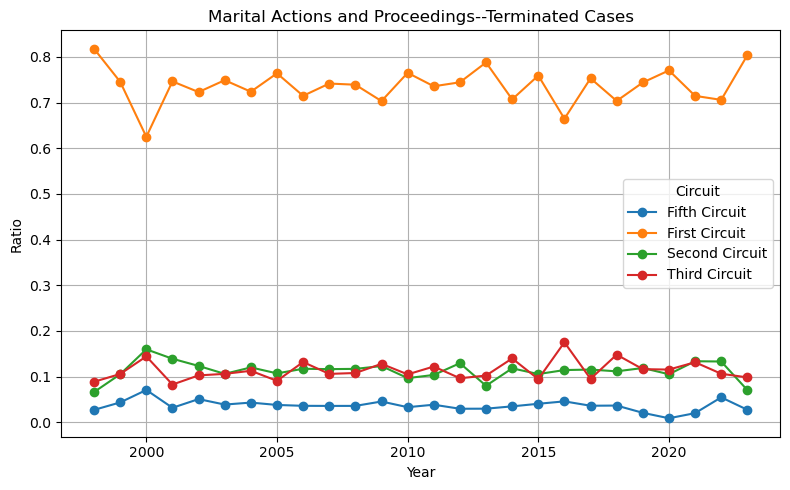

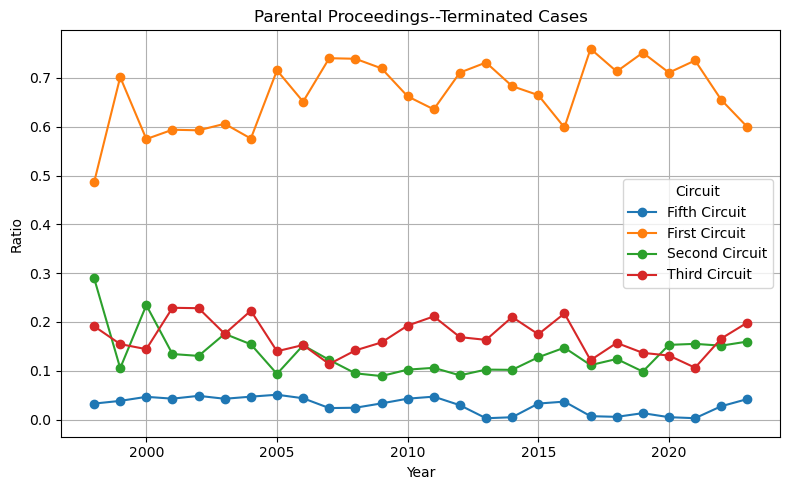

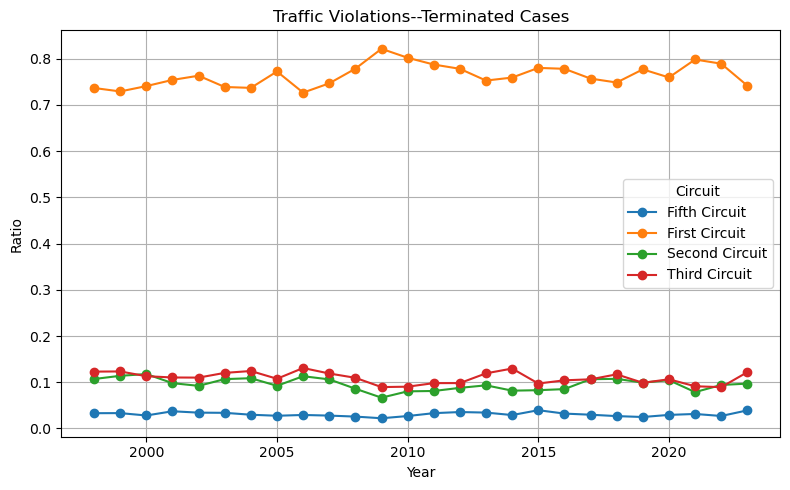

In [1016]:
## Plot ratios for each type of Terminated cases
# Group data by Case. COA cases were removed from the plot since the ratio is always one as the only one available
actions = df_caseload[df_caseload['Circuit'] != 'COA']['Type of Action'].unique()

# Plot each Case separately
for action in actions:
    # Filter the data for the current Action
    action_df = df_caseload[df_caseload['Type of Action'] == action]
    
    # Pivot data for easier plotting
    pivot_df = action_df.pivot_table(index='Year', columns='Circuit', values='Ratio_Terminated')

    # Plot
    plt.figure(figsize=(8, 5))
    for circuit in pivot_df.columns:
        plt.plot(pivot_df.index, pivot_df[circuit], marker='o', label=f'{circuit}')
    
    # Add labels, title, and legend
    plt.xlabel('Year')
    plt.ylabel('Ratio')
    plt.title(f'{action}--Terminated Cases')
    plt.legend(title='Circuit')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Preprocessing

In [1018]:
# filter to a specific case
y = df_caseload[(df_caseload['Circuit'] == 'First Circuit') & (df_caseload['Type of Action'] == 'Criminal Actions')].reset_index(drop=True)
#y = y[['Year', 'Total Caseload']]
y = y[['Year', 'Filed']]

In [1019]:
# limit years to where we have caseload data
X = (df_pred[(df_pred['Year'] >= 1998) & (df_pred['Year'] <= 2023)]).reset_index(drop=True)

<font size="4">Looks like 2020 is an outlier in the predictors data. Probably, it's better to drop it.</font>

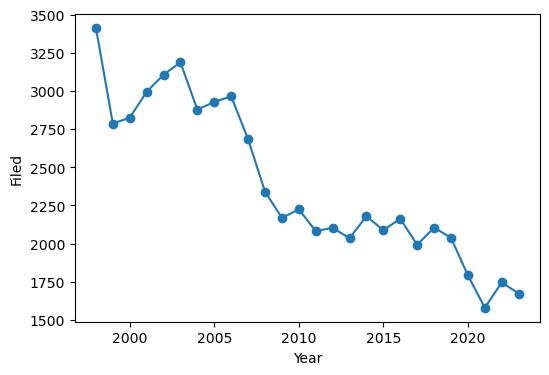

In [1021]:
# caseload trend over years
plt.figure(figsize=(6, 4))
plt.plot(y.iloc[:, 0], y.iloc[:,1], marker='o')
plt.xlabel(y.columns[0])
plt.ylabel(y.columns[1])
plt.show()

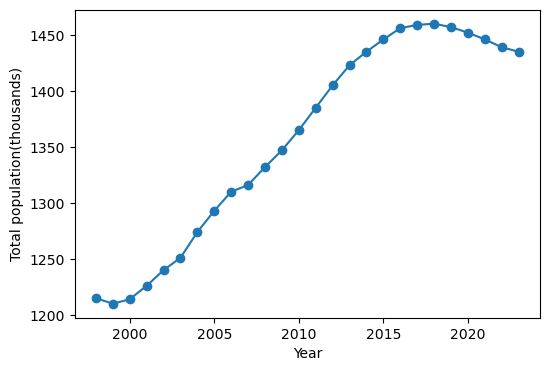

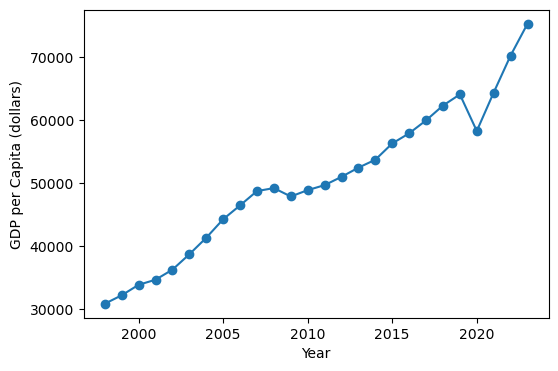

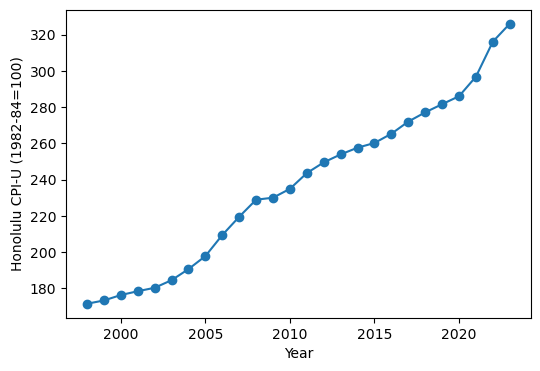

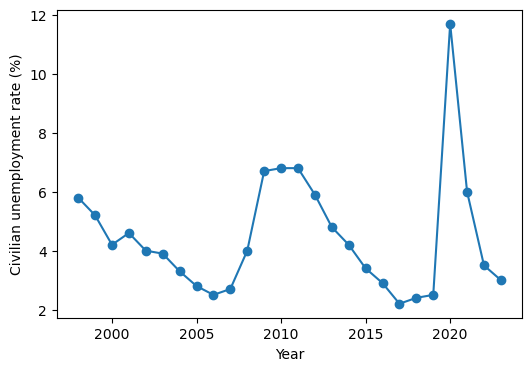

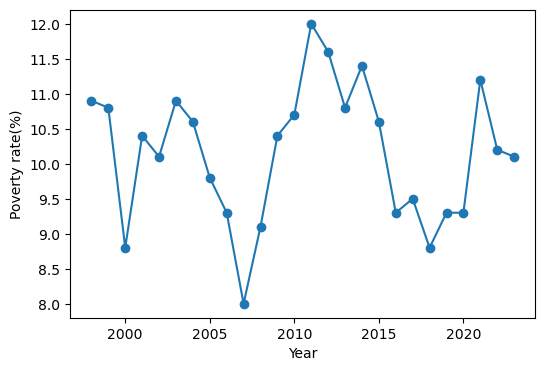

In [1022]:
# predictors trend over years
for col in X.drop(columns=['Year']).columns:
    plt.figure(figsize=(6, 4))
    plt.plot(X.iloc[:, 0], X[col], marker='o')
    plt.xlabel(X.columns[0])
    plt.ylabel(col)
    plt.show()

In [1023]:
# drop year 2020 data from target and predictors
X = X[X['Year'] != 2020]
y = y[y['Year'] != 2020]

In [1024]:
# split into training and test. we keep last three years for test
start_year = 1998 # first year for training data
end_year = 2018 # last year for training data

X_train = X[(X['Year'] <= end_year) & (X['Year'] >= start_year)].drop(columns=['Year']).reset_index(drop=True)
X_test = X[X['Year'] > end_year].drop(columns=['Year']).reset_index(drop=True)
y_train = y[(y['Year'] <= end_year) & (y['Year'] >= start_year)].drop(columns=['Year']).reset_index(drop=True)
y_test = y[y['Year'] > end_year].drop(columns=['Year']).reset_index(drop=True)

<font size="4">Correlation differs from training to test data which suggests that the training and test datasets come from different distributions.</font>

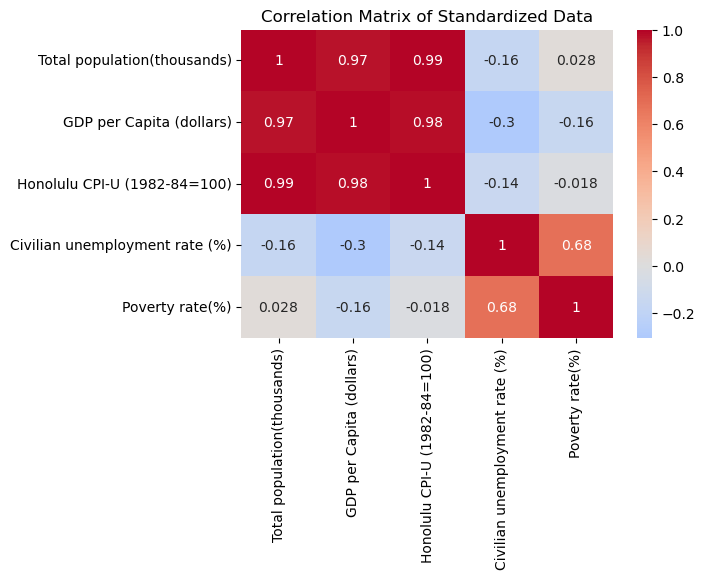

In [1026]:
# Calculate correlation between variables in training dataset
correlation_matrix = X_train.corr()
# Visualize correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Standardized Data")
plt.show()

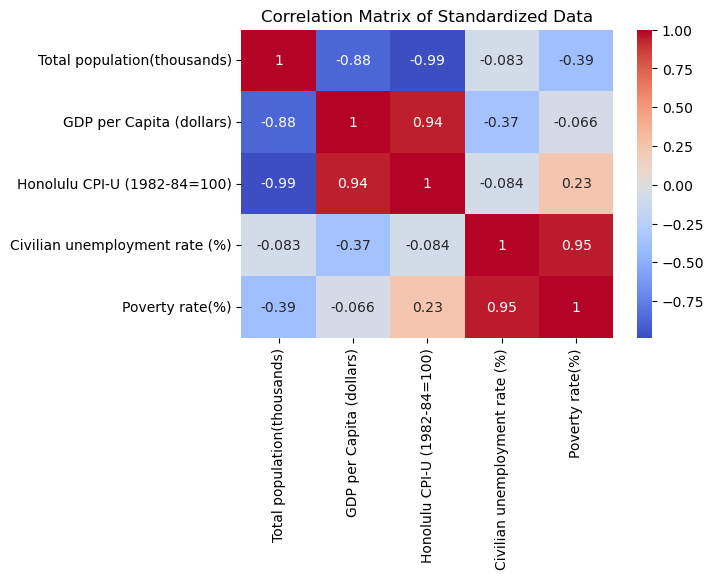

In [1027]:
# Calculate correlation between variables in test set
correlation_matrix = X_test.corr()

# Visualize correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Standardized Data")
plt.show()

<font size="4">The relationship between target variable and predictors is not linear in most cases.</font>

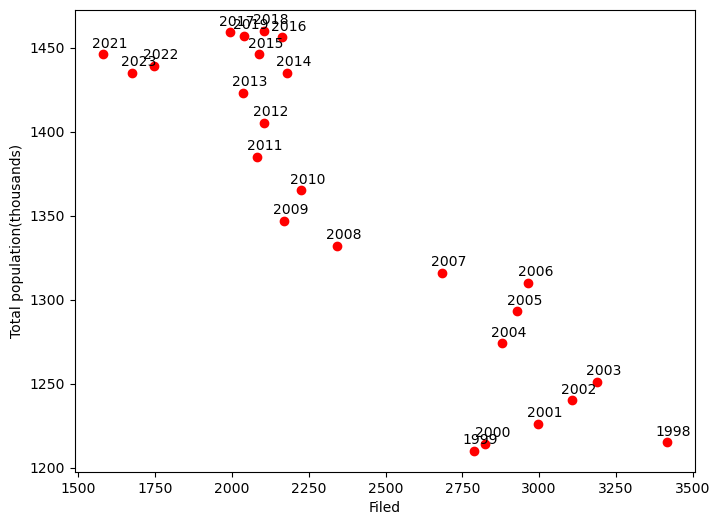

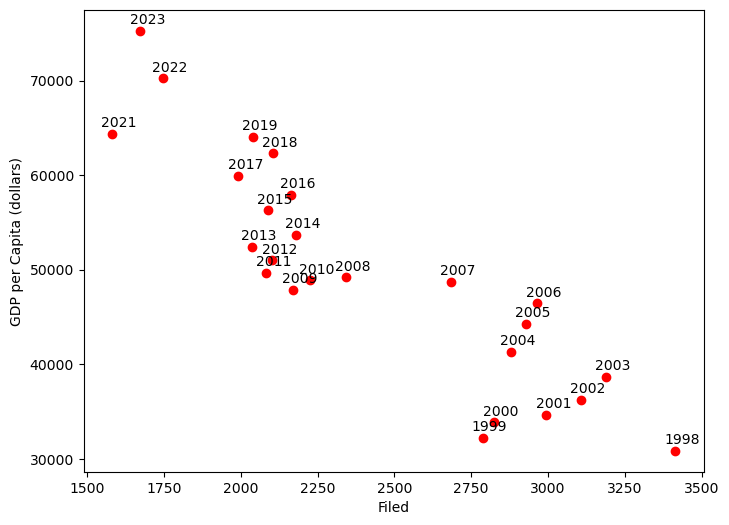

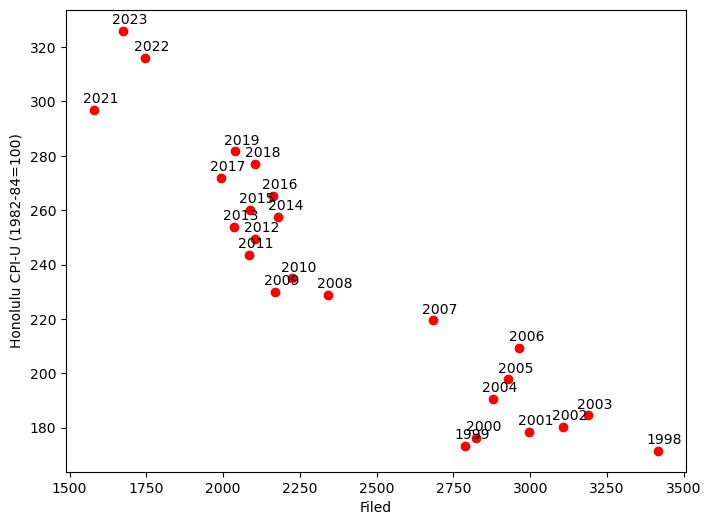

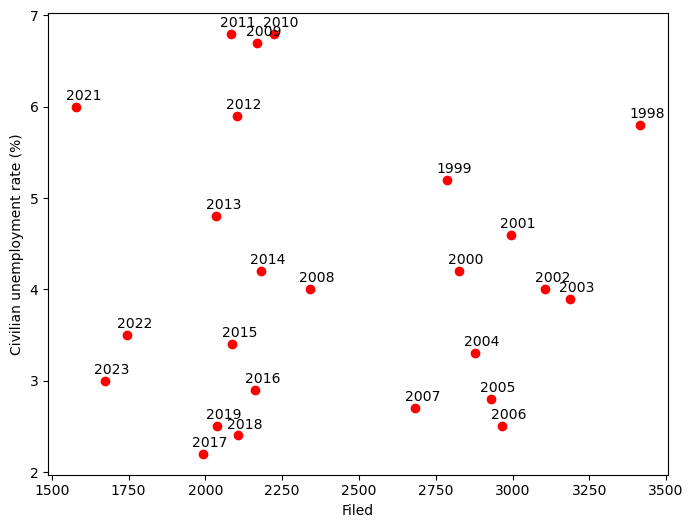

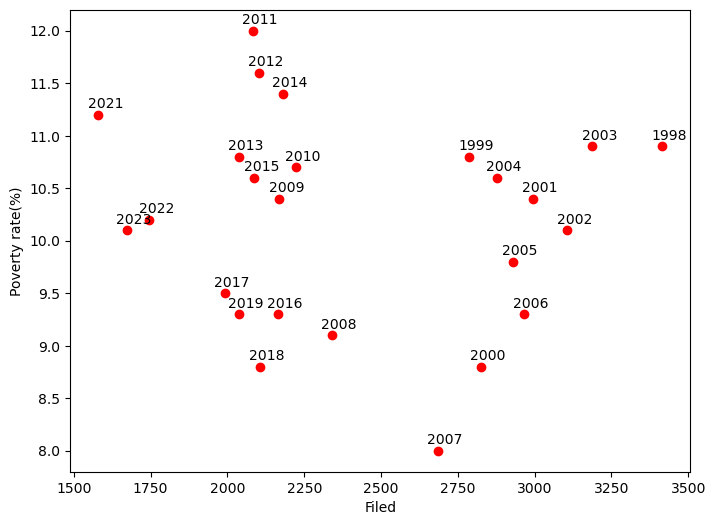

In [1029]:
# caseload vs. different predictors
for col in X_train.columns:
    plt.figure(figsize=(8, 6))
    plt.scatter(y.iloc[:,1], X[col], marker='o', color='red')
    # Add labels to each point
    for i, label in enumerate(y.iloc[:, 0]):
        plt.annotate(label, (y.iloc[i, 1], X[col].iloc[i]), textcoords="offset points", xytext=(5,5), ha='center')
    plt.xlabel(y.columns[1])
    plt.ylabel(col)
    plt.show()

In [1030]:
# standardize data to bring them into same scale
scaler = StandardScaler()
# Fit scaler on training data and transform both train and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training and Evaluation

## 1- ModelA: Considering all predictors

Mean Squared Error: 356473.9393770505
R-squared: -11.14078514312403


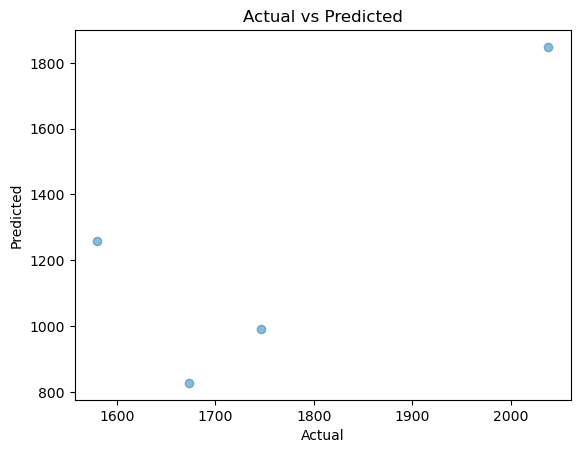

In [1033]:
modelA = LinearRegression()
modelA.fit(X_train_scaled, y_train)

# Make prediction
y_pred = modelA.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Visualize the results
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()

In [1034]:
# Check model coefficients
coefficients = modelA.coef_
intercept = modelA.intercept_
print("Coefficients (Standardized):", coefficients)
print("Intercept (Standardized):", intercept)

Coefficients (Standardized): [[ 313.57270352   91.26006906 -824.8970165   -90.92002687    9.45153258]]
Intercept (Standardized): [2536.04761905]


## 2- ModelB: Use L1 regularization
Gives better result but still not great!

Best alpha using 1-fold CV: 71.96856730011514
Best R2: 0.39760648445150826


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.194e+03, tolerance: 4.219e+02
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.563e+03, tolerance: 4.219e+02
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.112e+03, toleranc

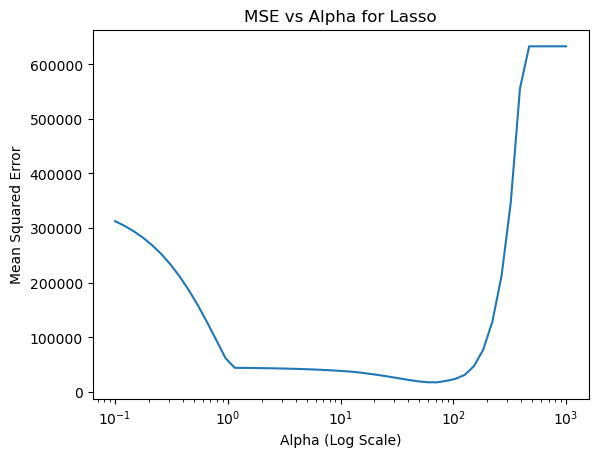

In [1036]:
# List of candidate alpha values
alphas = np.logspace(-1, 3, 50)

# List to store Mean Squared Errors for each alpha
mse_values = []
r2_values = []
# Loop over different alpha values to find the best one
for alpha in alphas:
    # Fit Lasso regression model with current alpha
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train_scaled, y_train)
    
    # Make predictions on the test set
    y_pred = lasso.predict(X_test_scaled)
    
    # Calculate the Mean Squared Error and R2 for the current alpha
    mse = mean_squared_error(y_test, y_pred)
    mse_values.append(mse)
    r2 = r2_score(y_test, y_pred)
    r2_values.append(r2)

# Find the alpha that results in the minimum MSE
best_alpha = alphas[np.argmin(mse_values)]
print("Best alpha using 1-fold CV:", best_alpha)
print(f"Best R2: {max(r2_values)}")

plt.plot(alphas, mse_values)
plt.xscale('log')
plt.xlabel('Alpha (Log Scale)')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Alpha for Lasso')
plt.show()

## Things to consider:
- We shoud look into more cases to see if there is a trend in data that gives us a clue to:
  - Get rid of some data points, or
  - Use more limited data; it looks like that 2012-2023 has a better trend
- Need to use regularization
- Predict Aggregated cases across all circuit courts